# <font color=#025dfa> Abalone Veri seti ile Yaş Tahmini Regresyon Modeli - Age Estimation with Abalone Dataset Regression Model

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, abalonların (deniz salyangozları) biyolojik özelliklerine dayanarak yaş tahmini yapmayı amaçlayan bir regresyon modeli geliştirmeyi hedeflemektedir. Verisetinde abalonların uzunluk, ağırlık, kabuk kalınlığı gibi çeşitli özellikleri kullanılarak, halkaları sayısı ile yaşları arasında ilişki kurulacaktır. Proje sonunda elde edilecek model, abalon yaş tahminini daha doğru bir şekilde yaparak, deniz biyolojisi ve türlerin korunması çalışmalarına katkı sağlamayı amaçlamaktadır.

EN = This project aims to develop a regression model that aims to estimate the age of abalones (sea snails) based on their biological characteristics. Various features of abalones such as length, weight, and shell thickness will be used in the dataset to establish a relationship between the number of rings and their age. The model that will be obtained at the end of the project aims to contribute to marine biology and species conservation studies by making abalone age estimates more accurate.

Kaynak/Source = https://www.kaggle.com/competitions/playground-series-s4e4

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import math
import warnings
warnings.filterwarnings('ignore')
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
pd.set_option("display.max_columns",None) 
# TR = En fazla kaç sütun olduğunu gösteriyor. 
# EN = It shows the maximum number of columns.

In [3]:
df=pd.read_csv('train.csv')

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [4]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
df.sample(5)

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
46018,46018,M,0.320,0.230,0.070,0.1165,0.0465,0.0390,0.045,6
14668,14668,I,0.460,0.345,0.120,0.4740,0.1955,0.1035,0.130,8
3559,3559,I,0.490,0.395,0.125,0.5150,0.2240,0.1080,0.165,12
46872,46872,M,0.695,0.540,0.160,1.5145,0.7150,0.4080,0.406,12
28481,28481,I,0.485,0.375,0.105,0.4900,0.1960,0.0990,0.145,8


In [6]:
df.tail()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6
90614,90614,I,0.425,0.325,0.100,0.3455,0.1525,0.0785,0.1050,8


In [7]:
df.shape

(90615, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [9]:
df.isnull().sum().sort_values(ascending=False)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [10]:
df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [11]:
df.corr(numeric_only=True)

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,1.000000,0.004724,0.004290,0.005916,0.005228,0.004203,0.004878,0.005887,0.000938
Length,0.004724,1.000000,0.989732,0.916094,0.931449,0.909609,0.913134,0.911073,0.623786
Diameter,0.004290,0.989732,1.000000,0.919618,0.933848,0.908466,0.914668,0.917871,0.636832
Height,0.005916,0.916094,0.919618,1.000000,0.902344,0.861769,0.886132,0.904019,0.665772
Whole weight,0.005228,0.931449,0.933848,0.902344,1.000000,0.971249,0.974319,0.964201,0.617274
Whole weight.1,0.004203,0.909609,0.908466,0.861769,0.971249,1.000000,0.949227,0.911800,0.515067
Whole weight.2,0.004878,0.913134,0.914668,0.886132,0.974319,0.949227,1.000000,0.937069,0.588954
Shell weight,0.005887,0.911073,0.917871,0.904019,0.964201,0.911800,0.937069,1.000000,0.694766
Rings,0.000938,0.623786,0.636832,0.665772,0.617274,0.515067,0.588954,0.694766,1.000000


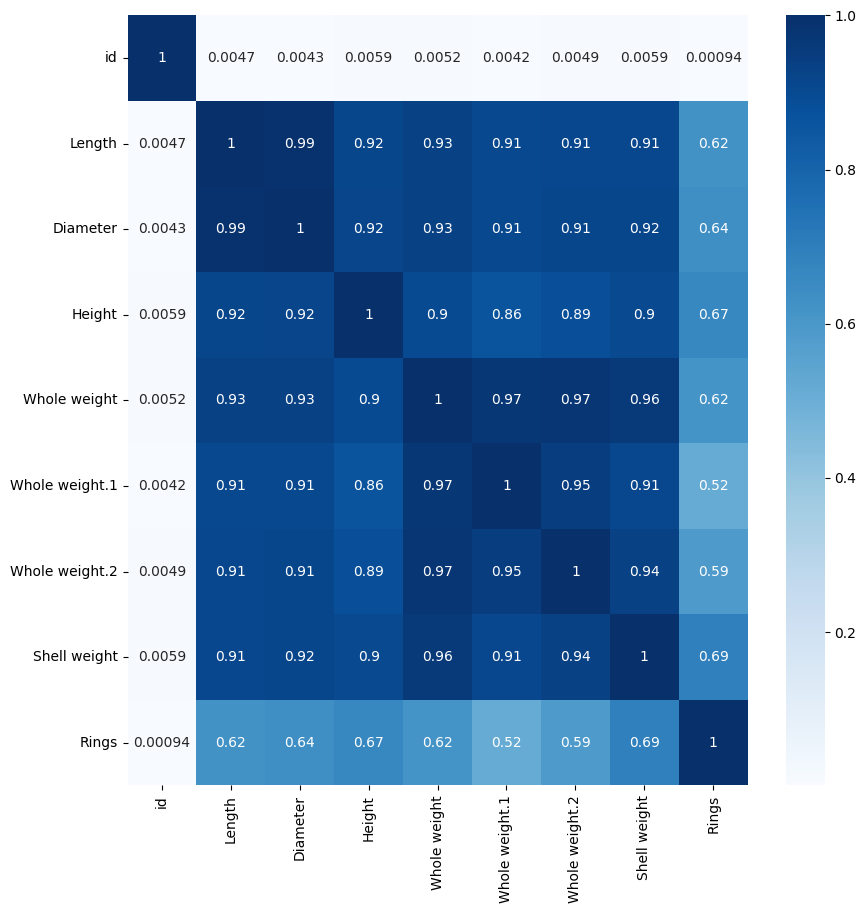

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Blues');

In [13]:
abs(df.corr(numeric_only=True)['Rings']).sort_values(ascending=False)

Rings             1.000000
Shell weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole weight      0.617274
Whole weight.2    0.588954
Whole weight.1    0.515067
id                0.000938
Name: Rings, dtype: float64

## <font color=#C0C0C0> Gereksiz Verileri Silme İşlemi Yapıyoruz - We Delete Unnecessary Data

In [14]:
df=df.drop('id',axis=1)
df.head(1)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.55,0.43,0.15,0.7715,0.3285,0.1465,0.24,11


## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [15]:
df.columns = df.columns.str.replace(r'[\s\.]', '_', regex=True)

In [16]:
df.isnull().sum().sort_values(ascending=False)

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Whole_weight_1    0
Whole_weight_2    0
Shell_weight      0
Rings             0
dtype: int64

### <font color=#ff2400> Sex Sütuna Bakıyoruz - We Look at the Column Sex

In [17]:
df['Sex']=df['Sex'].map({'F': 0, 'I': 1, 'M': 2}).astype(int)

In [18]:
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [19]:
df.isnull().sum().sort_values(ascending=False)

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Whole_weight_1    0
Whole_weight_2    0
Shell_weight      0
Rings             0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  int32  
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole_weight    90615 non-null  float64
 5   Whole_weight_1  90615 non-null  float64
 6   Whole_weight_2  90615 non-null  float64
 7   Shell_weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int32(1), int64(1)
memory usage: 5.9 MB


## <font color=#1cfc03> Aykırı Değer - Outlier

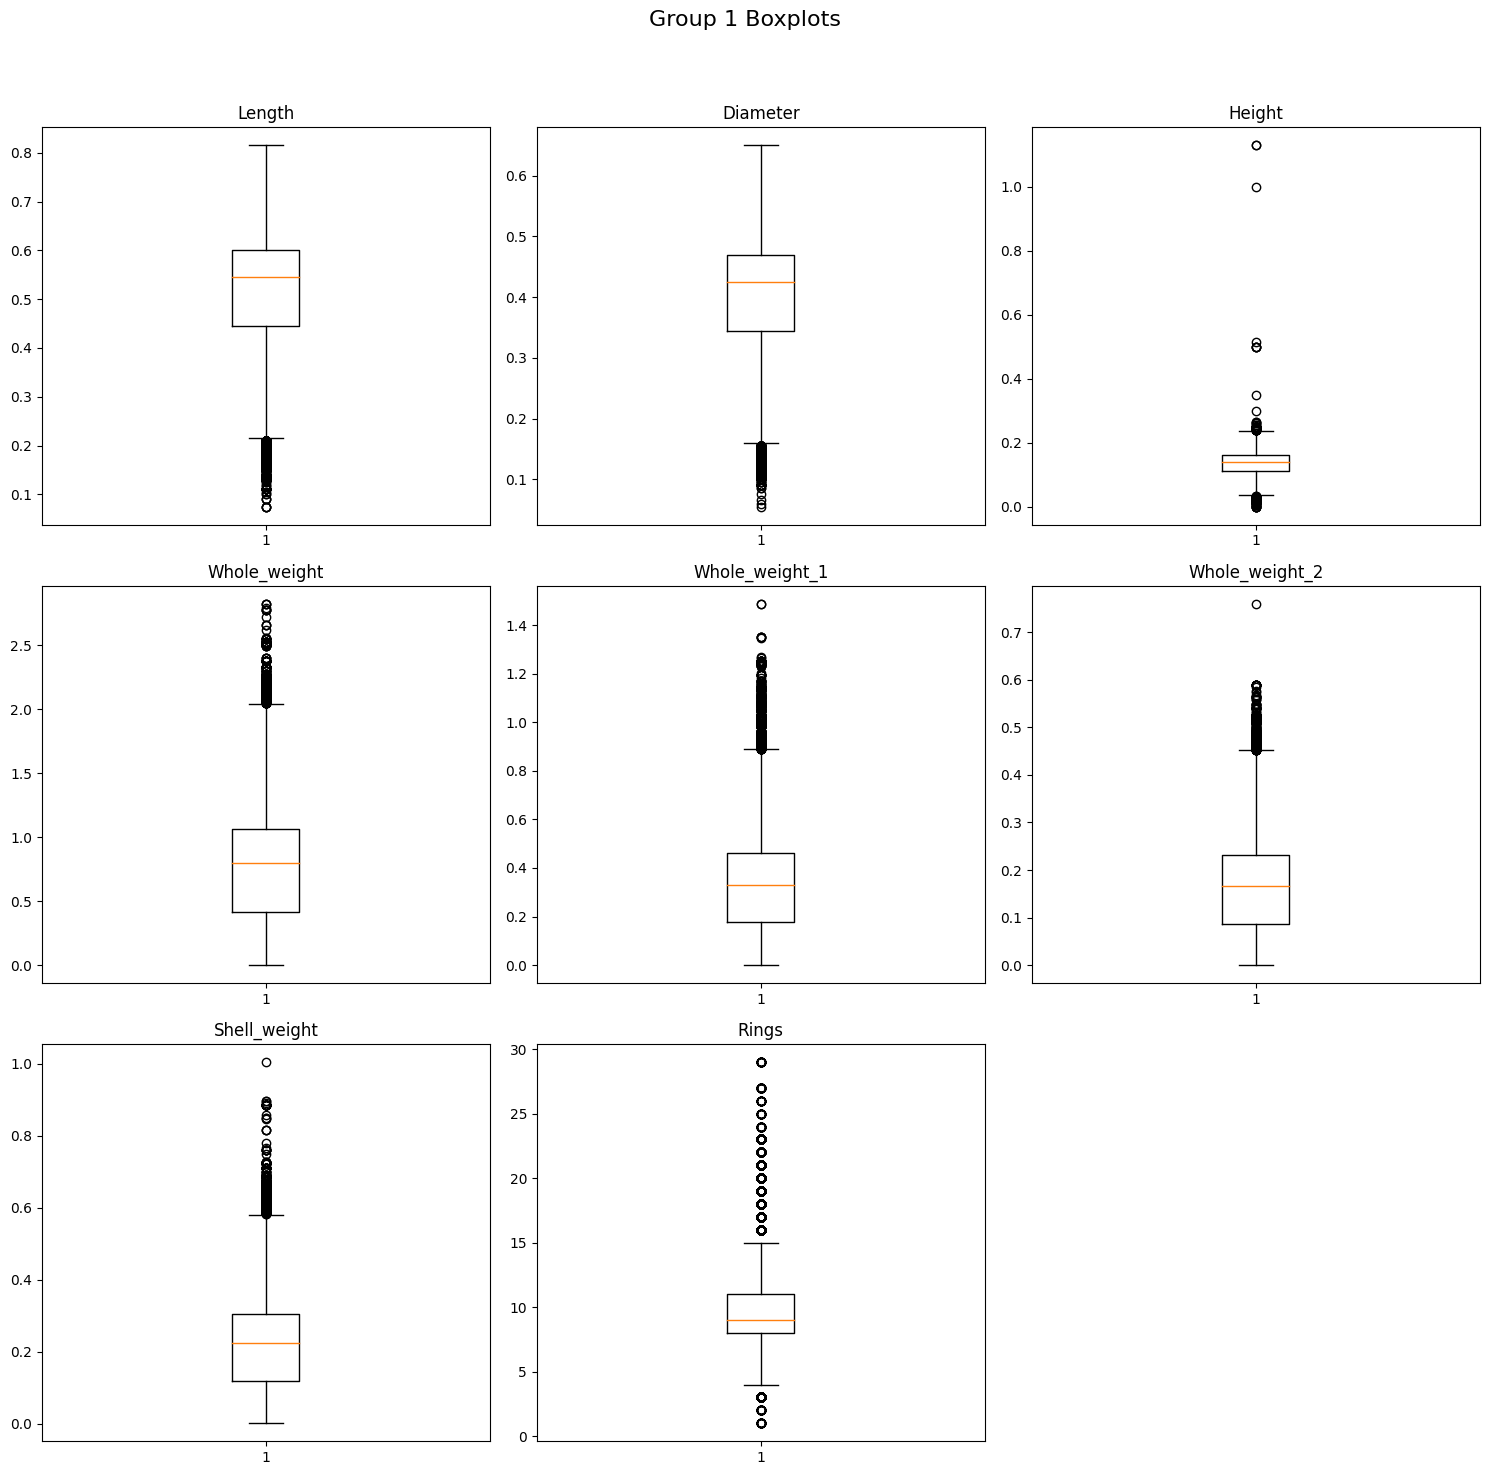

In [21]:
# Sadece int ve float sütunlarını seç
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Her bir subplot grubu 9 grafikten oluşacak şekilde grup sayısını hesapla
num_cols = len(numeric_cols)
num_plots_per_group = 9
num_groups = math.ceil(num_cols / num_plots_per_group)

# Boxplot çizimi
for group in range(num_groups):
    # Şu anki grubun sütunlarını seç
    cols_in_group = numeric_cols[group * num_plots_per_group:(group + 1) * num_plots_per_group]
    
    # Alt grafiklerin boyutunu ayarla
    num_plots = len(cols_in_group)
    rows = math.ceil(num_plots / 3)  # 3 sütun olacak şekilde düzenle
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    
    # Eğer sadece tek bir satır varsa, axs bir liste değil tek bir eksen olabilir
    axs = axs.flatten() if num_plots > 1 else [axs]
    
    # Seçilen her sütun için boxplot çiz
    for i, col in enumerate(cols_in_group):
        axs[i].boxplot(df[col].dropna())  # NaN değerleri düş
        axs[i].set_title(col)
    
    # Boş subplot'ları gizle
    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)
    
    # Grup numarasını belirt
    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Tabloların aralarındaki boşlukları düzenle
    plt.show()


In [22]:
# TR = Aykırı değer çok fazla olduğu için işlem yapmadık. 
# EN = We did not take any action because there were too many outliers.

## <font color=#e0c510> Verileri Görşelleştirme - Visualizing Data me

In [23]:
#for column in df.columns:
#    print(f"\nSütun:{column}")
#    unique=df[column].dropna().unique()
    
#    if pd.api.types.is_numeric_dtype(df[column]):
#        unique=sorted(unique)
        
#    print(f"Unique Değerler:{unique}")

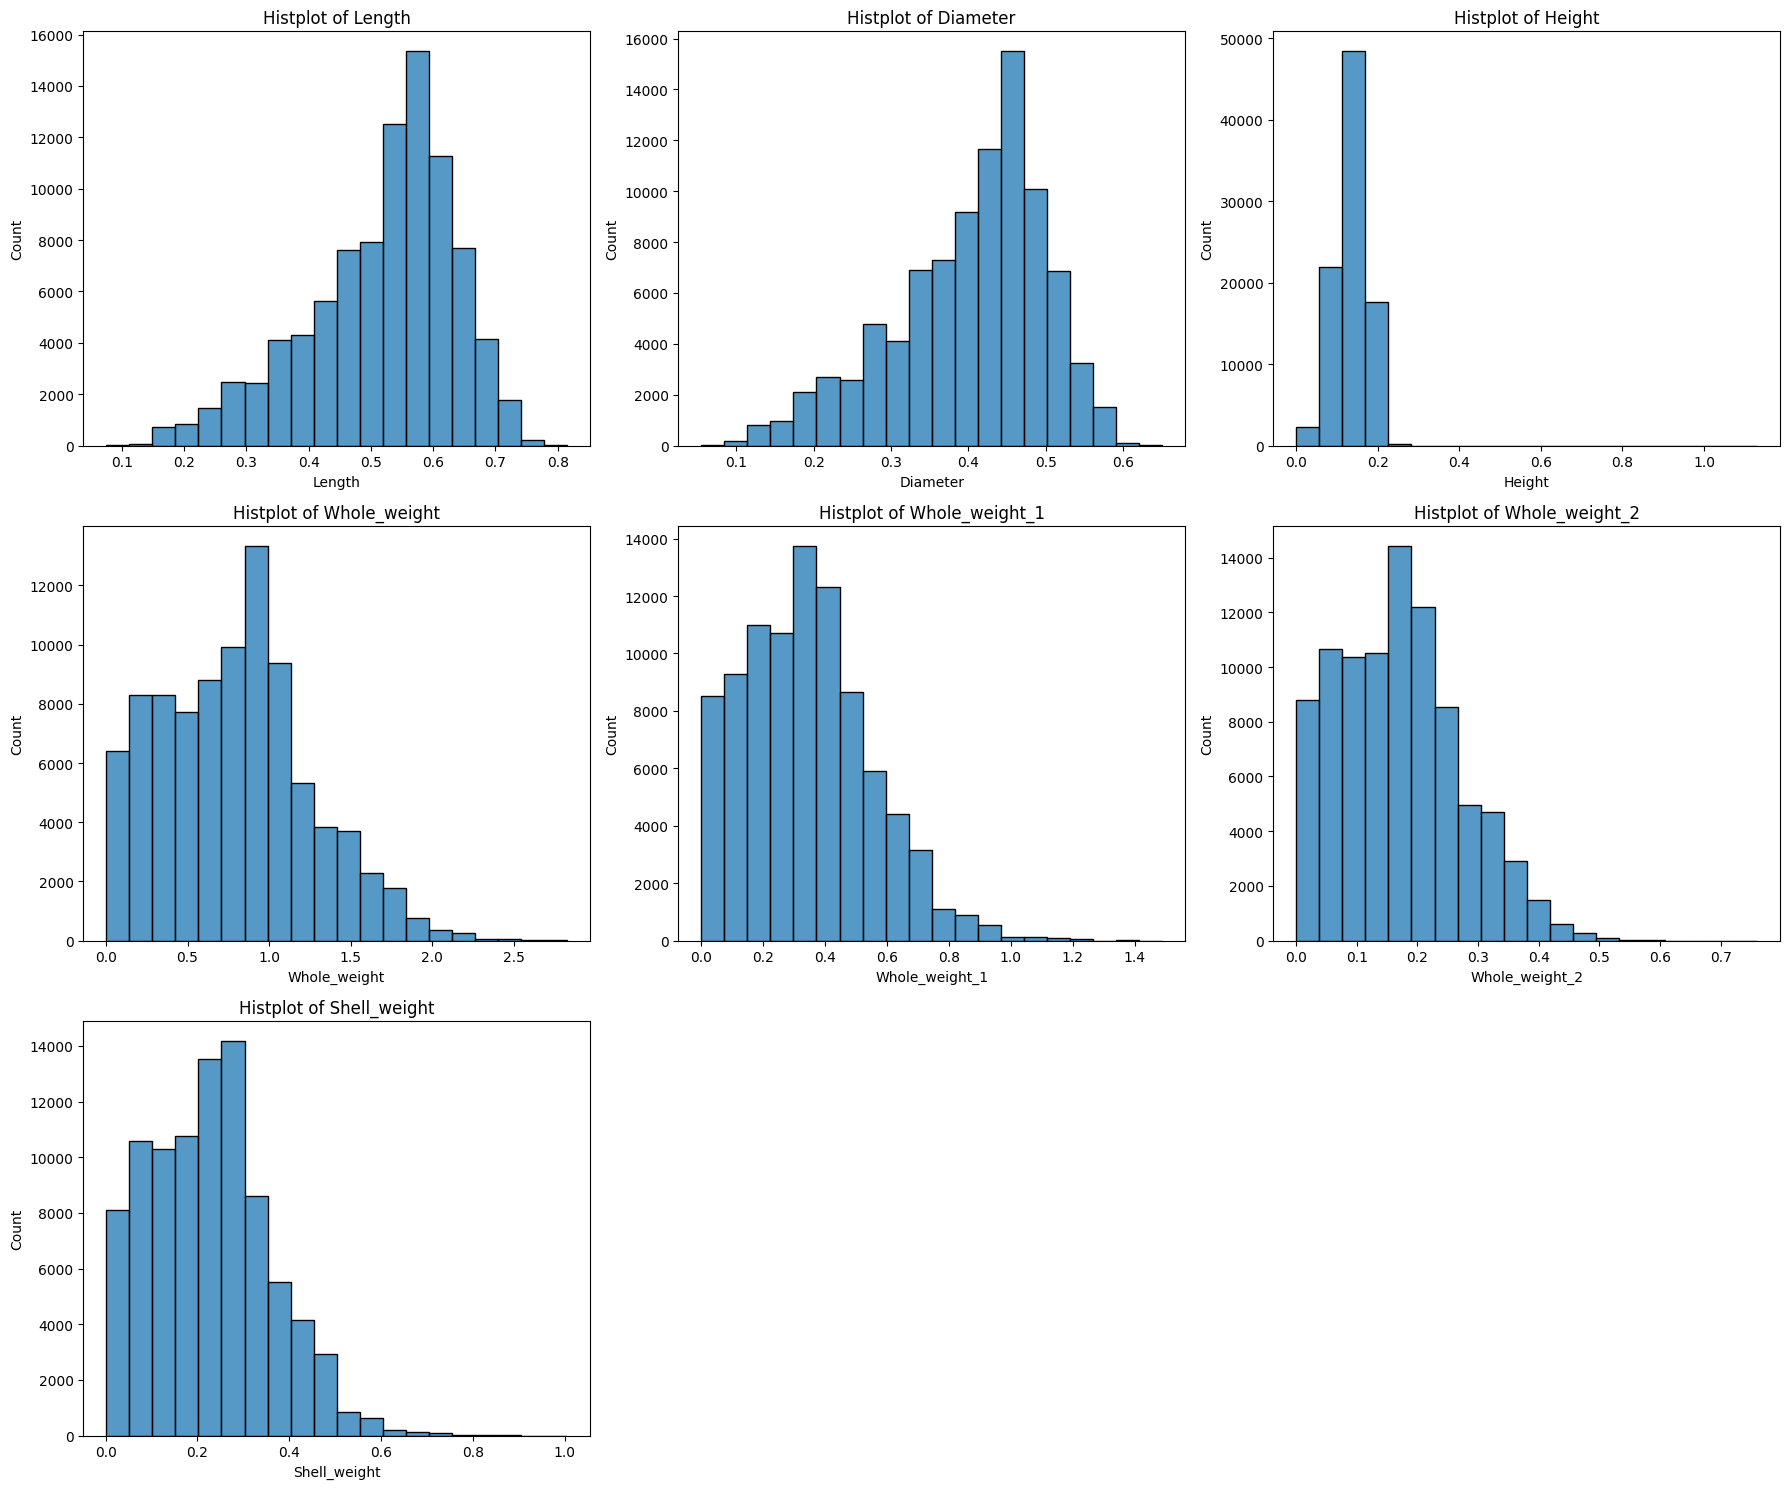

In [24]:
excluded_columns = ['Sex','Rings']  
# TR = excluded_columns'ma eşitlenmiş sütunları görselleştirmeden hariç tutuyoruz.
# EN = We exclude columns equal to excluded_columns from the visualization.

columns = [col for col in df.columns if col not in excluded_columns]
# TR = (in df.columns) df DataFrame içindeki (col for col)her sütuna bak.
# TR = (if col not in excluded_columns) excluded_columns değişkeninin içindeki sütun adlarına bakma.

# EN = (in df.columns) Look at each column in df DataFrame (col for col).
# EN = (if col not in excluded_columns) Look at the column names in the excluded_columns variable.

num_columns = len(columns)
# TR = sütun sayısını okuyup, num_columns değişkenine atadım.
# EN = I read the number of columns and assigned it to the num_columns variable.

fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(18, (num_columns // 3 + 1) * 5))
# TR = nrows=(num_columns // 3) + 1: Bu, oluşturulacak alt grafiklerin (subplot'ların) satır sayısını belirler.
# TR = num_columns // 3, toplam sütun sayısının 3'e bölünmesiyle elde edilen tam sayı değerdir. + 1 ise, sütun sayısı 3'e tam bölünmüyorsa ekstra bir satır ekler.
# TR = ncols=3: Bu, her satırda kaç tane alt grafik olacağını belirler. Bu örnekte, her satırda 3 alt grafik olacak şekilde ayarlanmıştır.  
# TR = figsize=(18, (num_columns // 3 + 1) * 5): Bu, oluşturulacak figürün (grafiklerin tümünün bulunduğu büyük alanın) boyutlarını ayarlar.
# TR = figsize parametresi, genişlik ve yükseklik değerlerini (18, (num_columns // 3 + 1) * 5) şeklinde alır. 
# TR = Genişlik 18 inç, yükseklik ise her satır için 5 inç olacak şekilde hesaplanır.

# EN = nrows=(num_columns // 3) + 1: This determines the number of rows of subplots to be created.
# EN = num_columns // 3 is the integer value obtained by dividing the total number of columns by 3. + 1 adds an extra row if the column count is not perfectly divisible by 3.
# EN = ncols=3: This determines how many subplots will be in each row. In this example, there will be 3 subplots per row.
# EN = figsize=(18, (num_columns // 3 + 1) * 5): This sets the size of the figure (the large area containing all the plots).
# EN = The figsize parameter takes the width and height values as (18, (num_columns // 3 + 1) * 5).
# EN = The width is 18 inches, and the height is calculated as 5 inches per row.


for i, column in enumerate(columns):  
    row = i // 3  
    # TR = Her sütunun hangi satırda gösterileceğini hesaplar (3 sütundan birinde)  
    # EN = Calculates which row each column should be displayed in (one of three columns)

    col = i % 3  
    # TR = Her sütunun hangi sütunda gösterileceğini hesaplar (0'dan 2'ye kadar)  
    # EN = Calculates which column each plot should be placed in (from 0 to 2)

    sns.histplot(data=df, bins=20, x=column, ax=axes[row, col])  
    # TR = (data=df) Veriyi df adlı DataFrame alacak.
    # TR = (bins=20) Histogramdaki çubuk sayısı 20 olarak ayarlar
    # TR = (x=column) column değişkenindeki sütunları alıp x eksenine eşitleyecek
    # TR = (ax=axes[row, col]) Tablonun yukarıdan ve soldan kaçıncı sırada duracağını beliler
    
    # EN = (data=df) Will take the data from the DataFrame named df.
    # EN = (bins=20) Sets the number of bars in the histogram to 20.
    # EN = (x=column) Takes the column from the variable and sets it to the x-axis.
    # EN = (ax=axes[row, col]) Specifies the position in the grid, indicating which row and column it will be placed in.


    axes[row, col].set_title(f'Histplot of {column}')  
    # TR = Grafiğin başlığını, ilgili sütun adı ile ayarlar  
    # EN = Sets the title of the plot to the name of the column


for j in range(i+1, len(axes.flat)):  
    # TR = Kullanılmayan alt grafikler (subplots) siliniyor  
    # EN = Removing unused subplots

    fig.delaxes(axes.flat[j])  
    # TR = Belirtilen alt grafiği (subplot) siler  
    # EN = Deletes the specified subplot from the figure

plt.tight_layout()  
# TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar  
# EN = Adjusts the layout for a tidy appearance

plt.show()  
# TR = Grafiği ekranda gösterir  
# EN = Displays the plot on the screen

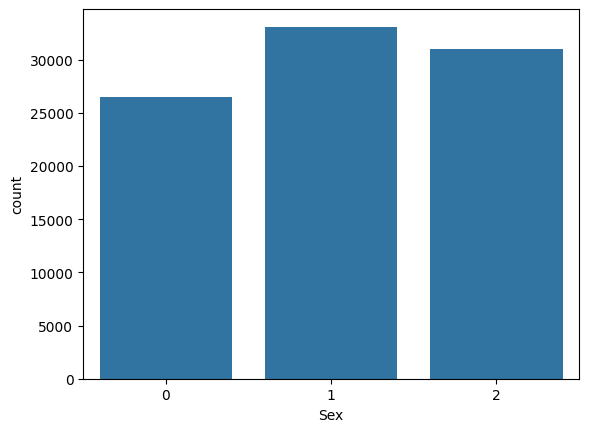

In [25]:
sns.countplot(x='Sex',data=df);

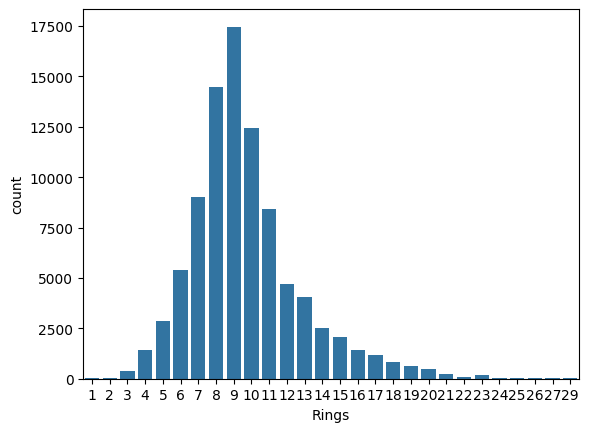

In [26]:
sns.countplot(x='Rings',data=df);

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [27]:
x=df.drop(['Rings'],axis=1)
y=df[['Rings']]

In [28]:
#x=pd.get_dummies(x,drop_first=True)
# Tr =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır. 
# En = It is used to convert categorical variables into numerical variables.

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [30]:
print(x_train.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Whole_weight_1',
       'Whole_weight_2', 'Shell_weight'],
      dtype='object')


In [31]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

In [32]:
model=Sequential()
model.add(Dense(1024,activation='relu',input_dim=x_train.shape[1]))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 256 nöron var.
# Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.
# EN = This layer connects all input neurons and learns the weights of each neuron. There are 256 neurons.
# Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(BatchNormalization())
# TR = Bu katman, modelin eğitim sürecini daha stabil hale getirmek için kullanılır.
# EN = This layer is used to make the training process of the model more stable.

model.add(Dropout(0.3))
# TR = Derin öğrenme modelinde aşırı uyumu (overfitting) azaltmak için kullanılır. Genelde 0.2 ile 0.5 arasında olur.
# EN = It is used to reduce overfitting in the deep learning model. It is generally between 0.2 and 0.5.

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
# TR = Derin öğrenme modelindeki çok boyutlu (2D, 3D vb.) verileri tek boyutlu bir vektöre dönüştürür.
# EN = It converts multidimensional (2D, 3D, etc.) data in the deep learning model into a one-dimensional vector.

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])  
# TR = Modelin kayıp fonksiyonu olarak 'mse' (ortalama kare hatası), optimizer olarak 'adam' ve performans metriği olarak 'mae' (ortalama mutlak hata) kullanılarak derlenmesini sağlar  
# EN = Compiles the model using 'mse' (mean squared error) as the loss function, 'adam' as the optimizer, and 'mae' (mean absolute error) as the performance metric

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

Epoch 1/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 37.7131 - mae: 4.8186 - val_loss: 4.2109 - val_mae: 1.3064
Epoch 2/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.7678 - mae: 1.7172 - val_loss: 3.7506 - val_mae: 1.3144
Epoch 3/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.3111 - mae: 1.6503 - val_loss: 3.8840 - val_mae: 1.2814
Epoch 4/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 5.2009 - mae: 1.6211 - val_loss: 3.8745 - val_mae: 1.2812
Epoch 5/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.9925 - mae: 1.5868 - val_loss: 3.7172 - val_mae: 1.2902
Epoch 6/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.9442 - mae: 1.5726 - val_loss: 3.7526 - val_mae: 1.3420
Epoch 7/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.8920 - mae: 1.5526 - val_loss: 3.7850 - val_mae: 1.3106
Epoch 8/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7891 - mae: 1.5341 - val_loss: 3.6934 - val_mae: 1.2918
Epoch 9/100
2266/2266 ━━━━━━

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,341 (1.76 MB)

 Trainable params: 153,281 (598.75 KB)

 Non-trainable params: 2,496 (9.75 KB)

 Optimizer params: 306,564 (1.17 MB)

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6435 - mae: 1.2800
Test doğruluğu: 1.2854


In [35]:
pred=model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik. 
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

567/567 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [36]:
r2_score(y_test,pred) 
# TR = Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır ve arasındaki farkı bul. 
# EN = Compare this with the actual (y_test) value and the predicted (pred) values ​​and find the difference between them.

0.6444457839226982

In [37]:
mean_squared_error(y_test,pred)**.5 
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.

1.911119952003279

In [38]:
mean_absolute_error(y_test,pred)
# TR = mean_absolute_error ile (y_test,pred) kullanarak değerini hesaplama. 
# EN = Calculating the value of mean_absolute_error using (y_test,pred).

1.2853769890185796

In [39]:
residuals=y_test-pred

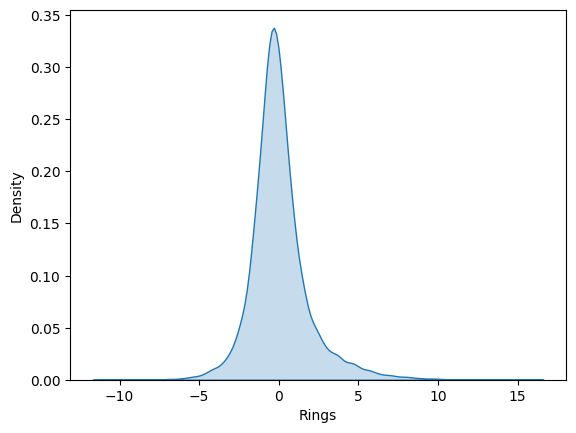

In [40]:
sns.kdeplot(x=residuals['Rings'],fill=True);
# TR = Veri dağılımını pürüzsüz bir şekilde tahmin etmek için kullanılan bir yoğunluk grafiğidir. Kernel Yoğunluk Tahmini (KDE) ile verinin altında yatan olasılık dağılımını görselleştirir.
# EN = It is a density plot used to smoothly estimate the distribution of data. It visualizes the underlying probability distribution of data using Kernel Density Estimation (KDE).

In [41]:
loss_f=pd.DataFrame(history.history)

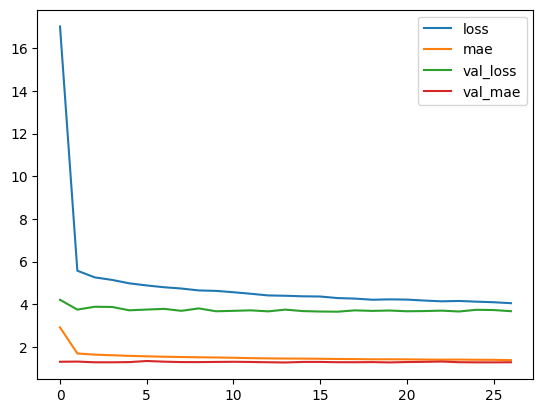

In [42]:
loss_f.plot();

In [43]:
pickle.dump(model,open('Abalone.pkl','wb'))